# Assumptions of Linear Regression

In the previous sub-sections, we have forged ahead and learned how to use OLS linear regression to estimate the linear relationship between variables and estimate the robustness of this relationship using the correlation coefficient.

But, before we continue end our discussion of linear regression, we must address the underlying **assumptions** that go into it. 

First, and foremost, you should **look at your data** and assess suitability, i.e., whether it even makes sense to try to find a linear relationship between to variables. [Figure 13](linear) shows four different scatter plots that all have about the same r-squared value, but clearly show very different relationships between the predictor and predictand and some are not appropriately modelled using a linear relationship between x and y.

```{figure} linear.png
---
scale: 50%
name: linear
---
Scatter plots including the best fit line.
```

Beyond the assumption of suitability, here are four other assumptions that we will go through one by one:

- Homoscedasticity of residuals (Goldfeld-Quandt test)

- No autocorrelation of residuals (Durbin-Watson test)

- The independent (predictor) variables and residuals are uncorrelated

- The residuals are normally distributed (normality test)

In other words: the residuals are *independent normal random variables with mean zero and constant variance*.

## 1. Homoscedasticity of the Residuals

This assumption states that the variance of the residuals should be approximately constant across different ranges of values of the predictor. This condition is known as **homoscedasticity**. If the variance changes, we refer to that as **heteroscedasticity**.

The most straight-forward way to assess whether your residuals are homoscedastic is to plot the residuals as a function of $x$. [Figure 14](scedastic) shows an example of this.

```{figure} scedasticity.png
---
scale: 50%
name: scedastic
---
Scatter plots of $y$ versus $x$ and the residuals versus $x$ for residuals the are (left) heteroscedastic and (right) homoscedastic.
```

What we want is displayed in the right column of [Figure 14](scedastic). If you see that the spread changes as a function of $x$, as in the left column of [Figure 14](scedastic), then a quantitative test is in order.

### Goldfeld-Quandt Test

The test we will use is called the [Goldfeld-Quandt test](https://www.statisticshowto.com/goldfeld-quandt-test/), which in essence tests whether or not the variances of the residuals for two different segments of your data are significantly different from each other using a statistic that we have not seen before, the $F$-statistic.

*In general*, the $F$-statistic is used to assess the ratio between two sample standard deviations, $s_1$ and $s_2$. f s1 and s2 are the variances of independent random samples of size N1 and N2, taken from two normal populations having true variances $\sigma_1$ and $\sigma_2$, respectively, then we can define $F$ as:

$$
F = \frac{s_1}{s_2}
$$

$F$ is a random variable that follows an [$F$-distribution](https://statisticsbyjim.com/anova/f-tests-anova/) with parameters $\nu_1$ = $N_1$ - 1 and $\nu_2$ = $N_2$ - 1.

*For the Goldfeld-Quandt test*, the variances that we are comparing are the sums of squared errors for the two sets of residuals that we compute for different segments of our data:

$$
F = \frac{\frac{Q_1}{(N_1 - 1)}}{\frac{Q_2}{(N_2 -1)}}
$$

where $Q_1$ and $Q_2$ are the sums of squared errors (see the Introduction to Linear Regression section). The null hypothesis of this test is that the sums of squared errors are the same, i.e. the residuals are homoscedastic.

Let's test the homoscedasticity assumption for our ENSO and California precipitation data.

In [1]:
# load packages
import numpy as np
import pickle as pickle
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',size=16,weight='bold') #set default font size and weight for plots

Let's load in our ENSO and California precipitation data again.

In [2]:
# ENSO Data:
# unpickle NINO34 (units of degC)
with open('NINO34_NDJF_2021.pickle','rb') as fp: #.pickle files are a python file type
    nino34 = pickle.load(fp,encoding='latin1')

In [3]:
#  Precipitation Data:
#  unpickle CA_PRECIP_DJFM (units of mm/day)
with open('CA_PRECIP_DJFM.pickle','rb') as fp: #.pickle files are a python file type
    precip_djfm = pickle.load(fp,encoding='latin1')

The first thing we should do is compute our residuals. So, we first need to compute the best fit line again.

In [4]:
# calculate the best fit parameters
slope, intercept, r_value, p_value, s_a1 = st.linregress(nino34,precip_djfm)

# calculate fit
y_hat = intercept + nino34*slope

The residuals then become,

In [5]:
# calculate residuals
resids = y_hat - precip_djfm

Let's plot the residuals first to see if we can detect any heteroscedasticity.

Text(0.5, 1.0, 'Scatter Plot: Residuals vs. NINO3.4')

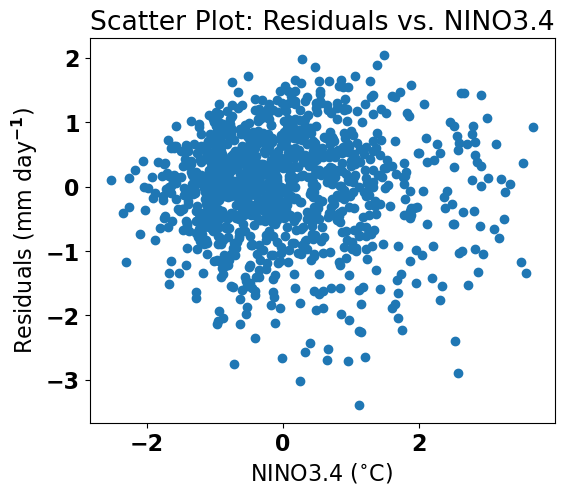

In [6]:
# plot residuals

plt.figure(figsize=(6,5))
plt.scatter(nino34,resids)
plt.xlabel('NINO3.4 ($^{\circ}$C)')
plt.ylabel('Residuals (mm day$^{-1}$)')
plt.title('Scatter Plot: Residuals vs. NINO3.4')

It's a bit hard to tell from this plot. Let's try the Goldfeld-Quandt test. To use this test we need to import a new python package: `statsmodels`.

In [7]:
# test for homoscedasticity
from statsmodels.stats.diagnostic import het_goldfeldquandt

nino34ex = np.expand_dims(nino34,axis=1) # we need to reshape nino34 to use this test

# the output of the het_goldfeldquandt test is the F-statistic and the p-value.
GQtest = het_goldfeldquandt(precip_djfm,nino34ex,alternative='increasing')
print(GQtest[1])

0.7524116536948657


Thus, we can accept the null hypothesis of homoscedasticity given the large p-value.

## 2. No Autocorrelation of Residuals (Durbin-Watson test)

The condition that the residuals should be independent means that one residual should not be able to predict the next. But, if the residuals contain a trend or periodicity, then the residuals are not truly independent and are **autocorrelated** (see [Figure 15](autocorr)). 

```{figure} autocorr.png
---
scale: 50%
name: autocorr
---
Scatter plots of the residuals versus $x$ for residuals the have (left) no autocorrelation and (right) autocorrelation.
```

For the residuals of our ENSO-California precipitation regression, the plot above of the residuals versus ENSO no not appear to have a trend or any periodicity. We can visualize this more quantitatively by examining a plot of the autocorrelation.

We are going to discuss autocorrelation in much more detail in the coming sections, but for now, let's plot the correlation of the residuals with themselves but as a function of lag. By lag we mean that we want to see how the residual for $x_1$ correlates with the residual of $x_2$ and $x_3$ and $x_4$, etc.

Let's compute the autocorrelation and then plot it. We will use the function `np.correlate()` to do this.

In [8]:
# calculate the autocorrelation of residuals

acorr = np.correlate(resids/(np.std(resids)),resids/(np.std(resids)*len(resids)),'same')

We will plot this as a function of lag. For residuals that have no autocorrelation, we expect to see a correlation of exactly 1.0 at a lag of zero and a correlation of approximately zero at all other lags.

Text(0.5, 1.0, 'Autocorrelation of the Residuals')

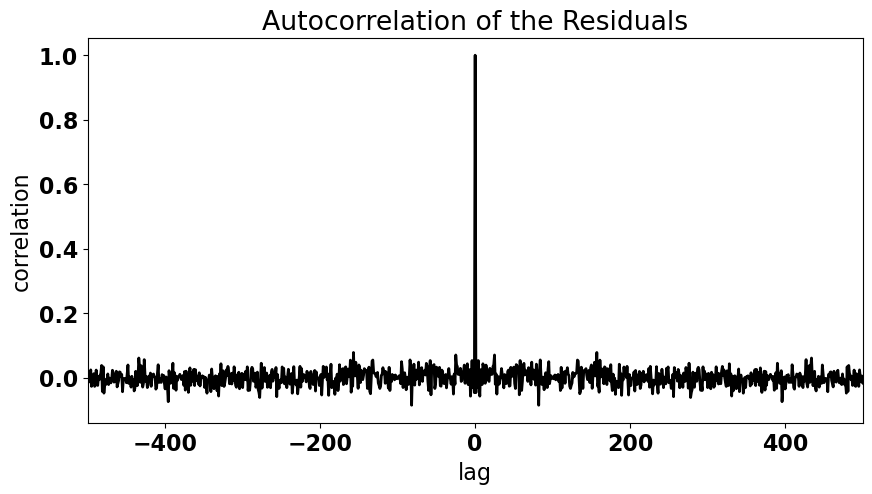

In [9]:
# plot the autocorrelation as a function of lag
fig = plt.figure(figsize=(10,5))

# define a variable for lag
x = np.arange(0,len(resids),1)
lag = [i-len(resids)/2 for i in x]

# plot acorr
plt.plot(lag,acorr,'k',linewidth=2,label='resids')
plt.xlim(-500,500)
plt.xlabel("lag")
plt.ylabel("correlation")
plt.title("Autocorrelation of the Residuals")

Looks like we have no autocorrelation in our residuals. We can also determine if our residuals are autocorrelated using the **Durbin-Watson** test. But, I always recommend using plots, like the one above, to support statistical tests. 

For the Durbin-Watson test, a value of 2 indicates no autocorrelation.

In [10]:
#  test for autocorrelation of residuals
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(resids)
print(dw)

2.091526951032455


Just like we thought - we find a value close to 2 - our residuals are not autocorrelated.

## 3. The Independent (Predictor) Variable and Residuals are Uncorrelated

If our predictor variable and our residuals are correlated, this means that, in theory, we could use the predictor variable to predict the residual, which violates the condition that our residuals should be *random*. 

A simple test of the correlation between the predictor and the residuals tells us if we need to redesign our model. Let's do this for our example data.

In [11]:
# test for correlation between the residuals and ENSO

corr_test,p = st.pearsonr(nino34,resids)
print(corr_test,p)

-8.901299836105991e-17 0.9999999999992325


Great! There is no correlation between ENSO and the residuals of the model.

## 4. The Residuals are Normally Distributed (Normality test)

The final assumption of OLS linear regression is that the residuals should be normally distributed. As before, we can first get a sense of this by making a plot; this time a histogram of the residuals.

Let's take a look.

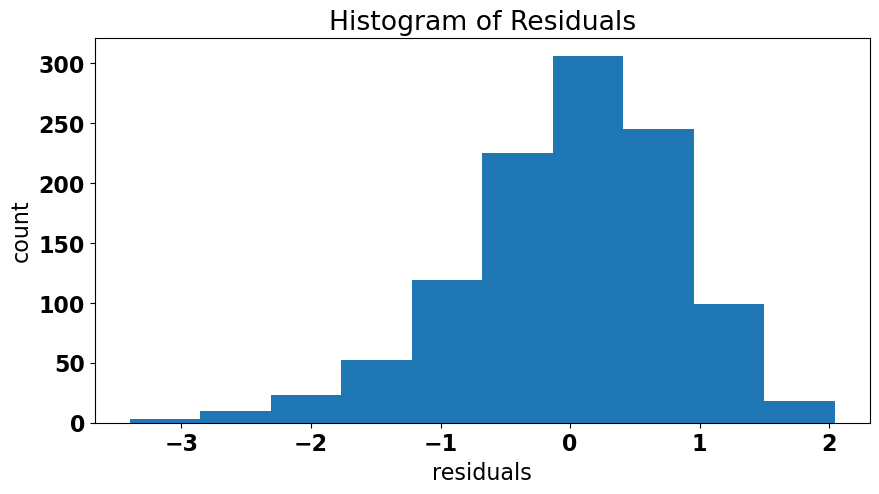

In [12]:
# histogram of residuals
fig = plt.figure(figsize=(10,5))
plt.hist(resids)
plt.xlabel("residuals")
plt.ylabel("count")
plt.title("Histogram of Residuals")
plt.show()

It looks like our residuals are somewhat negatively skewed. It's possible that this distribution deviates sufficiently from a normal distribution. We can perform a more quantitative test to confirm this suspicion. There are a few different options, but we with use the `stats.normaltest()` function which is a test that examines both the skewness and kurtosis of a distribution to assess normality.

In [13]:
# test for normality of residuals

nt = st.normaltest(resids)
print(nt[1]) # this is the p-value output

4.1808325127178547e-16


Our test for normality is violated, because the probability that our null hypothesis is true, that the distribution is normal, is very small.

This tells us that our model needs a bit of improvement.  

### Aside: Transformations

Sometimes there are ways that we can transform our data such that all assumptions are satisfied. In the case of our ENSO-California precipitation model, the fact that the residuals are not normal is related to the fact that the precipitation data is not normal (precipitation can never go below zero, which skews the data to the right). We can see this if we plot the histogram of precipitation.

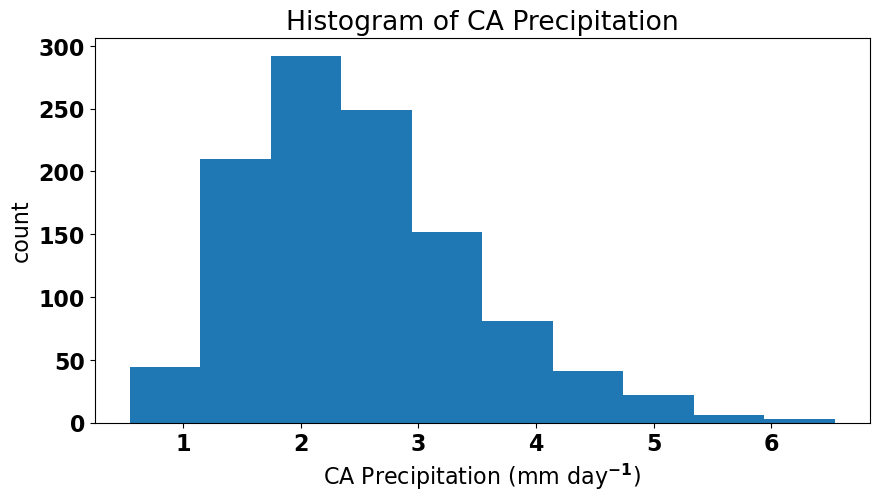

In [14]:
# histogram of precipitation
fig = plt.figure(figsize=(10,5))
plt.hist(precip_djfm)
plt.xlabel("CA Precipitation (mm day$^{-1}$)")
plt.ylabel("count")
plt.title("Histogram of CA Precipitation")
plt.show()

One possible transformation is to take the square-root of precipitation and see if that helps.

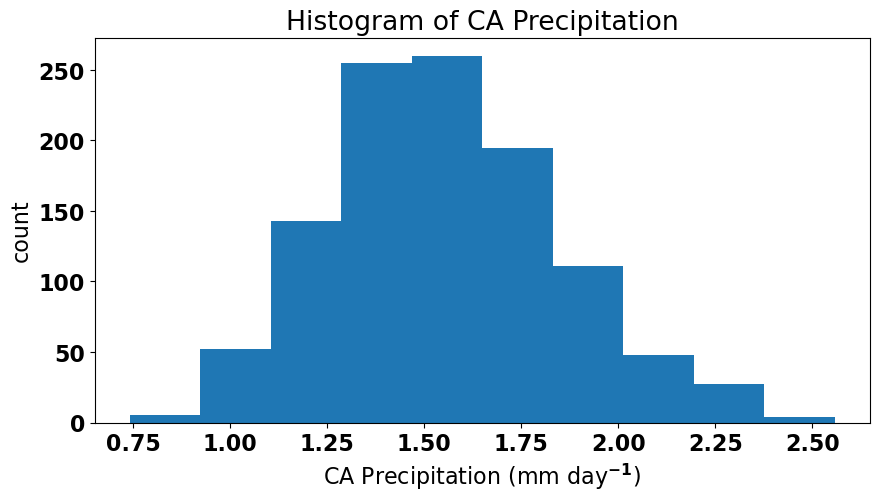

In [15]:
# histogram of square-root of precipitation
fig = plt.figure(figsize=(10,5))
plt.hist(np.sqrt(precip_djfm))
plt.xlabel("CA Precipitation (mm day$^{-1}$)")
plt.ylabel("count")
plt.title("Histogram of CA Precipitation")
plt.show()

Now, it looks a bit better. If we are using our regression model to make a prediction (rather than using it to support our undersanding of physical relationships), we want our model to be as good as possible and to satisfy all the conditions outlined above. So, let's see if the residuals pass the normal test if we change our regression model slightly to use the square-root of precipition instead. 

In [16]:
# calculate the best fit parameters using square-root of precipitation
slope, intercept, r_value, p_value, s_a1 = st.linregress(nino34,np.sqrt(precip_djfm))

# calculate fit
y_hat_alt = intercept + nino34*slope

# calculate residuals
resids_alt = y_hat_alt - np.sqrt(precip_djfm)

# redo the normal test
nt_alt = st.normaltest(resids_alt)
print(nt_alt[1]) # this is the p-value output

0.16190967395193617


With this square-root transformation our resids now satisfy the condition that they should be normally distributed.